In [ ]:
# imports
import os
import numpy as np
# for visualization of our dataset
import matplotlib.pylab as plt
# tensorflow for model development
import tensorflow as tf
# model repository
import tensorflow_hub as hub
# dataset repository
import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Using the stanford_dogs dataset
# with_info will allow us to have dataset metadata
# as_supervised will download the target labels for the data
# there are two splits in this dataset i.e. train and test.
# dataset will be a list, in which 0 index refers to train and 1 refers to test. 
# info will be having the metadata.

datasets, info = tfds.load(name='stanford_dogs', with_info=True, as_supervised=True, split=['train','test']) # 'test','validation'

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteJUJ0PI/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteJUJ0PI/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
# info about the dataset.
info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

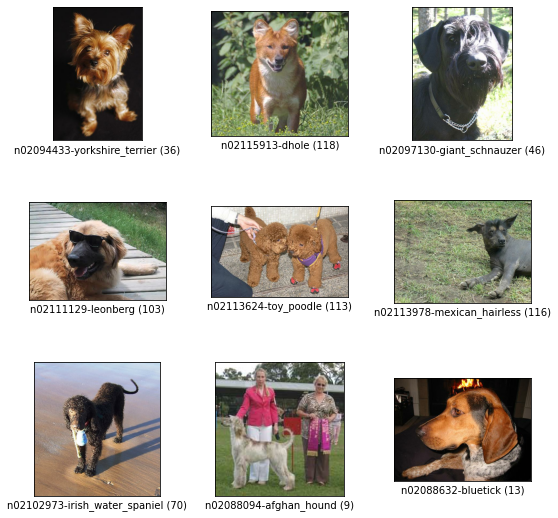

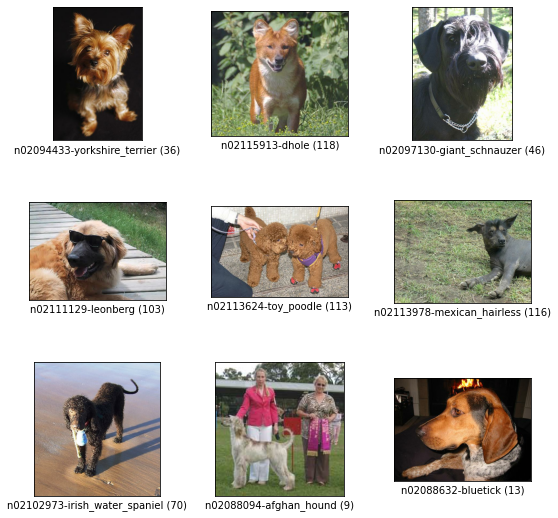

In [ ]:
# Visualize the example images in train dataset
# datasets[0] will contain the image name and info will contain the target class name
tfds.show_examples(datasets[0], info) 

##### Reference Doc: [show_examples](https://www.tensorflow.org/datasets/api_docs/python/tfds/visualization/show_examples)


In [ ]:
# scaling the dataset
# So, that each pixel range gets between 0 to 1.
# resizing into shape 224 x 224 with 3 for being RGB. (As mobile net requires imgs into 224x224 shape)
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255.0 
  return tf.image.resize(image, [224,224]), tf.one_hot(label, 120)

In [ ]:
# to batch the data
# default size is 32
def get_dataset(batch_size=32):
  train_dataset_scaled = datasets[0].map(scale).shuffle(1000).batch(batch_size)
  test_dataset_scaled = datasets[1].map(scale).batch(batch_size)
  return train_dataset_scaled , test_dataset_scaled

In [ ]:
# get the dataset after scaling
# the dataset will be cached into GPU memory
train_dataset, test_dataset = get_dataset()
train_dataset.cache()

<CacheDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>

In [ ]:
# Getting the Pre-trained Mobile Net V2 model
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [ ]:
# Having model till the final layer
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(224,224,3)) 

In [ ]:
# train the last layer
feature_extractor_layer.trainable = False

In [ ]:
# feature_extractor_layer will extract out all the features from the imgs using the pre-trained weights
# droping the 30% of the weights
# adding the final dense layer with number of classes i.e. 120 and softmax as activation function 
# you can add your own layers as well.
model = tf.keras.Sequential([
                             feature_extractor_layer,
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(120,activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               153720    
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# optimizer is Adam
# loss function is categorical entropy
# metric is accuracy
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [ ]:
# training the model
history = model.fit(train_dataset, epochs=2)

Epoch 1/2
375/375 [==============================] - 287s 753ms/step - loss: 1.4151 - acc: 0.6426
Epoch 2/2
375/375 [==============================] - 282s 748ms/step - loss: 0.4980 - acc: 0.8487


In [ ]:
# testing the model
result=model.evaluate(test_dataset)

269/269 [==============================] - 202s 747ms/step - loss: 0.5641 - acc: 0.8237


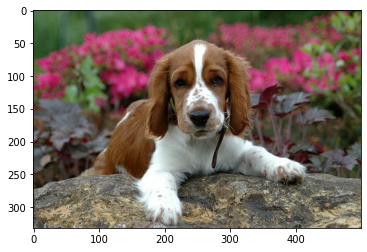

Actual Label: n02102177-welsh_springer_spaniel
Predicted Label: n02102177-welsh_springer_spaniel


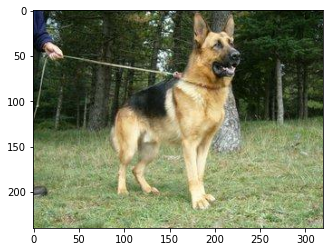

Actual Label: n02106662-german_shepherd
Predicted Label: n02106662-german_shepherd


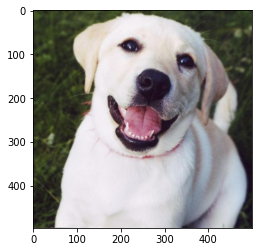

Actual Label: n02099712-labrador_retriever
Predicted Label: n02099712-labrador_retriever


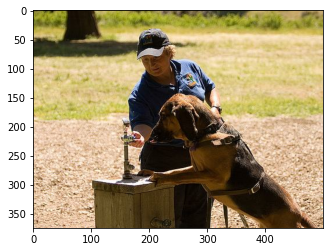

Actual Label: n02088466-bloodhound
Predicted Label: n02087394-rhodesian_ridgeback


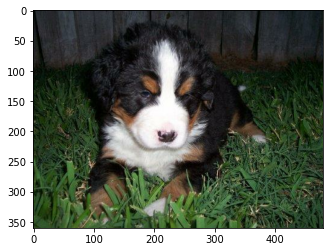

Actual Label: n02107683-bernese_mountain_dog
Predicted Label: n02107683-bernese_mountain_dog


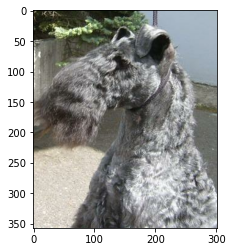

Actual Label: n02093859-kerry_blue_terrier
Predicted Label: n02093859-kerry_blue_terrier


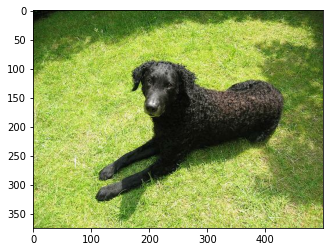

Actual Label: n02099429-curly-coated_retriever
Predicted Label: n02099429-curly-coated_retriever


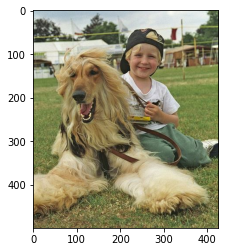

Actual Label: n02088094-afghan_hound
Predicted Label: n02088094-afghan_hound


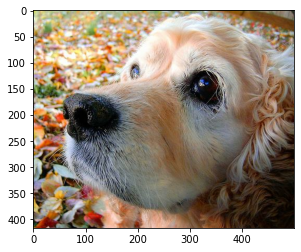

Actual Label: n02102318-cocker_spaniel
Predicted Label: n02102318-cocker_spaniel


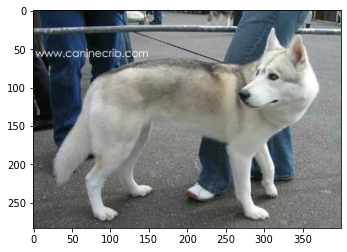

Actual Label: n02110185-siberian_husky
Predicted Label: n02110185-siberian_husky


In [ ]:
# taking 10 imgs from test dataset
for test_sample in datasets[1].take(10): 
  image, label = test_sample[0], test_sample[1]
  image_scaled, label_arr = scale(test_sample[0], test_sample[1])
  image_scaled = np.expand_dims(image_scaled, axis=0)

  img= tf.keras.preprocessing.image.img_to_array(image)
  pred=model.predict(image_scaled)
  plt.figure()
  plt.imshow(image) # the output img will be the orignal one not the scaled one
  plt.show()
  print("Actual Label: %s" % info.features["label"].names[label.numpy()])
  print("Predicted Label: %s" % info.features["label"].names[np.argmax(pred)])

In [ ]:
# saving the model
model.save('models')

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


### Download Model Files

In [ ]:
# Compressing the model dir files.
!zip -r models.zip 'models/'

  adding: models/ (stored 0%)
  adding: models/saved_model.pb (deflated 92%)
  adding: models/variables/ (stored 0%)
  adding: models/variables/variables.index (deflated 78%)
  adding: models/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/assets/ (stored 0%)
  adding: models/keras_metadata.pb (deflated 81%)
